# Tutorial: Training convolutional neural networks with nolearn

Author: [Benjamin Bossan](https://github.com/benjaminbossan)

This tutorial's goal is to teach you how to use [nolearn](https://github.com/dnouri/nolearn) to train convolutional neural networks (CNNs). The nolearn documentation can be found [here](https://pythonhosted.org/nolearn/). We assume that you have some general knowledge about machine learning in general or neural nets specifically, but want to learn more about convolutional neural networks and nolearn.

We well cover several points in this notebook.

1. How to [load image data](#Loading-MNIST-data) such that we can use it for our purpose. For this tutorial, we will use the MNIST data set, which consists of images of the numbers from 0 to 9.
2. How to [properly define layers](#Definition-of-the-layers) of the net. A good choice of layers, i.e. a good network architecture, is most important to get nice results out of a neural net.
3. The definition of the [neural network](#Definition-of-the-neural-network) itself. Here we define important hyper-parameters.
4. Next we will see how [visualizations](#Visualizations) may help us to further refine the network.
5. Finally, we will show you how nolearn can help us find [better architectures](#Finding-a-good-architecture) for our neural network.

## Imports

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv2DLayer
from lasagne.layers import MaxPool2DLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from lasagne.layers import get_all_params

In [4]:
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective

Note: If your GPU supports it, you should try using *lasagne.cuda_convnet.Conv2DCCLayer* and *lasagne.cuda_convnet.MaxPool2DCCLayer*, which could give you a nice speed up.

## Loading MNIST data

This little helper function loads the MNIST data available [here](https://www.kaggle.com/c/digit-recognizer/data).

In [6]:
def load_mnist(path):
    X = []
    y = []
    with open(path, 'rb') as f:
        next(f)  # skip header
        for line in f:
            yi, xi = line.split(',', 1)
            y.append(yi)
            X.append(xi.split(','))

    # Theano works with fp32 precision
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.int32)

    # apply some very simple normalization to the data
    X -= X.mean()
    X /= X.std()

    # For convolutional layers, the default shape of data is bc01,
    # i.e. batch size x color channels x image dimension 1 x image dimension 2.
    # Therefore, we reshape the X data to -1, 1, 28, 28.
    X = X.reshape(
        -1,  # number of samples, -1 makes it so that this number is determined automatically
        1,   # 1 color channel, since images are only black and white
        28,  # first image dimension (vertical)
        28,  # second image dimension (horizontal)
    )

    return X, y

In [7]:
# here you should enter the path to your MNIST data
#path = os.path.join(os.path.expanduser('~'), 'data/mnist/train.csv')

In [11]:
#X, y = load_mnist(path)
from sklearn.datasets import load_digits
d=load_digits()
X=d.images
y=d.target

ValueError: total size of new array must be unchanged

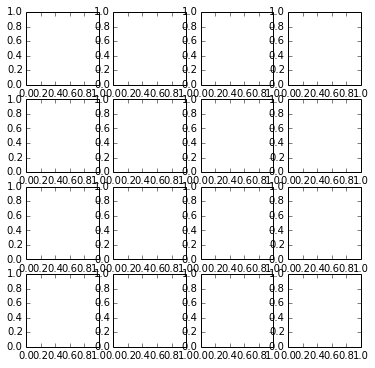

In [12]:
figs, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(-X[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("Label: {}".format(y[i + 4 * j]))
        axes[i, j].axis('off')

## Definition of the layers

So let us define the layers for the convolutional net. In general, layers are assembled in a list. Each element of the list is a tuple -- first a Lasagne layer, next a dictionary containing the arguments of the layer. We will explain the layer definitions in a moment, but in general, you should look them up in the [Lasagne documenation](http://lasagne.readthedocs.org/en/latest/modules/layers.html).

Nolearn allows you to skip Lasagne's _incoming_ keyword, which specifies how the layers are connected. Instead, nolearn will automatically assume that layers are connected in the order they appear in the list.

*Note: Of course you can manually set the *incoming* parameter if your neural net's layers are connected differently. To do so, you have to give the corresponding layer a name (e.g. *'name': 'my layer'*) and use that name as a reference (*'incoming': 'my layer'*).*

The layers we use are the following:

* _InputLayer_: We have to specify the _shape_ of the data. For image data, it is batch size x color channels x image dimension 1 x image dimension 2 (aka bc01). Here you should generally just leave the batch size as _None_, so that it is taken care off automatically. The other dimensions are given by _X_.
* _Conv2DLayer_: The most important keywords are _num_filters_ and _filter_size_. The former indicates the number of channels -- the more you choose, the more different filters can be learned by the CNN. Generally, the first convolutional layers will learn simple features, such as edges, while deeper layers can learn more abstract features. Therefore, you should increase the number of filters the deeper you go. The _filter_size_ is the size of the filter/kernel. The current consensus is to always use 3x3 filters, as these allow to cover the same number of image pixels with fewer parameters than larger filters do.
* _MaxPool2DLayer_: This layer performs max pooling and hopefully provides translation invariance. We need to indicate the region over which it pools, with 2x2 being the default of most users.
* _DenseLayer_: This is your vanilla fully-connected layer; you should indicate the number of 'neurons' with the _num_units_ argument. The very last layer is assumed to be the output layer. We thus set the number of units to be the number of classes, 10, and choose _softmax_ as the output nonlinearity, as we are dealing with a classification task.
* _DropoutLayer_: Dropout is a common technique to regularize neural networks. It is almost always a good idea to include dropout between your dense layers.

Apart from these arguments, the Lasagne layers have very reasonable defaults concerning weight initialization, nonlinearities (rectified linear units), etc.

In [ ]:
layers0 = [
    # layer dealing with the input data
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    # first stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    # the output layer
    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

## Definition of the neural network

We now define the neural network itself. But before we do this, we want to add L2 regularization to the net (see [here](http://cs231n.github.io/neural-networks-2/#reg) for more). This is achieved in the little helper function below. If you don't understand exactly what this about, just ignore this.

In [ ]:
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses

Now we initialize nolearn's neural net itself. We will explain each argument shortly:
* The most important argument is the _layers_ argument, which should be the list of layers defined above.
* _max_epochs_ is simply the number of epochs the net learns with each call to _fit_ (an 'epoch' is a full training cycle using all training data). 
* As _update_, we choose _adam_, which for many problems is a good first choice as updateing rule.
* The _objective_ of our net will be the _regularization_objective_ we just defined.
* To change the _lambda2_ parameter of our objective function, we set the _objective_lambda2_ parameter. The NeuralNetwork class will then automatically set this value. Usually, moderate L2 regularization is applied, whereas L1 regularization is less frequent.
* For 'adam', a small learning rate is best, so we set it with the _update_learning_rate_ argument (nolearn will automatically interpret this argument to mean the _learning_rate_ argument of the _update_ parameter, i.e. adam in our case).
* The NeuralNet will hold out some of the training data for validation if we set the _eval_size_ of the _TrainSplit_ to a number greater than 0. This will allow us to monitor how well the net generalizes to yet unseen data. By setting this argument to 1/4, we tell the net to hold out 25% of the samples for validation.
* Finally, we set _verbose_ to 1, which will result in the net giving us some useful information.

In [ ]:
net0 = NeuralNet(
    layers=layers0,
    max_epochs=10,

    update=adam,
    update_learning_rate=0.0002,

    objective=regularization_objective,
    objective_lambda2=0.0025,

    train_split=TrainSplit(eval_size=0.25),
    verbose=1,
)

### Training the neural network

To train the net, we call its _fit_ method with our X and y data, as we would with any [scikit learn](http://scikit-learn.org) classifier.

In [ ]:
net0.fit(X, y)

As we set the verbosity to 1, nolearn will print some useful information for us:

* First of all, some _general information_ about the net and its layers is printed. Then, during training, the progress will be printed after each epoch. 
* The _train loss_ is the loss/cost that the net tries to minimize. For this example, this is the _log loss_ (_cross entropy_).
* The _valid loss_ is the loss for the hold out validation set. You should expect this value to indicate how well your model generalizes to yet unseen data.
* _train/val_ is simply the ratio of train loss to valid loss. If this value is very low, i.e. if the train loss is much better than your valid loss, it means that the net has probably [overfitted](https://en.wikipedia.org/wiki/Overfitting) the train data.
* When we are dealing with a classification task, the accuracy score of the valdation set, _valid acc_, is also printed.
* _dur_ is simply the duration it took to process the given epoch.

In addition to this, nolearn will color the as of yet best train and valid loss, so that it is easy to spot whether the net makes progress.

## Visualizations

Diagnosing what's wrong with your neural network if the results are unsatisfying can sometimes be difficult, something closer to an art than a science. But with nolearn's visualization tools, we should be able to get some insights that help us diagnose if something is wrong.

In [ ]:
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

### Train and validation loss progress

With nolearn's visualization tools, it is possible to get some further insights into the working of the CNN. First of all, we will simply plot the log loss of the training and validation data over each epoch, as shown below:

In [ ]:
plot_loss(net0)

This kind of visualization can be helpful in determining whether we want to continue training or not. For instance, here we see that both loss functions still are still decreasing and that more training will pay off. This graph can also help determine if we are overfitting: If the train loss is much lower than the validation loss, we should probably do something to regularize the net.

### Visualizing layer weights

We can further have a look at the weights learned by the net. The first argument of the function should be the layer we want to visualize. The layers can be accessed through the *layers_* attribute and then by name (e.g. 'conv2dcc1') or by index, as below. (Obviously, visualizing the weights only makes sense for convolutional layers.)

In [ ]:
plot_conv_weights(net0.layers_[1], figsize=(4, 4))

As can be seen above, in our case, the results are not too interesting. If the weights just look like noise, we might have to do something (e.g. use more filters so that each can specialize better).

## Visualizing the layers' activities

To see through the "eyes" of the net, we can plot the activities produced by different layers. The *plot_conv_activity* function is made for that. The first argument, again, is a layer, the second argument an image in the bc01 format (which is why we use _X[0:1]_ instead of just _X[0]_).

In [ ]:
x = X[0:1]

In [ ]:
plot_conv_activity(net0.layers_[1], x)

Here we can see that depending on the learned filters, the neural net represents the image in different ways, which is what we should expect. If, e.g., some images were completely black, that could indicate that the corresponding filters have not learned anything useful. When you find yourself in such a situation, training longer or initializing the weights differently might do the trick.

### Plot occlusion images

A possibility to check if the net, for instance, overfits or learns important features is to occlude part of the image. Then we can check whether the net still makes correct predictions. The idea behind that is the following: If the most critical part of an image is something like the head of a person, that is probably right. If it is instead a random part of the background, the net probably overfits (see [here](http://www.matthewzeiler.com/pubs/arxive2013/arxive2013.pdf) for more).

With the *plot_occlusion* function, we can check this. The first argument is the neural net, the second the X data, the third the y data. Be warned that this function can be quite slow for larger images.

In [ ]:
plot_occlusion(net0, X[:5], y[:5])

Here we see which parts of the number are most important for correct classification. We ses that the critical parts are all directly above the numbers, so this seems to work out. For more complex images with different objects in the scene, this function should be more useful, though.

## Finding a good architecture

This section tries to help you go deep with your convolutional neural net. To do so, one cannot simply increase the number of convolutional layers at will. It is important that the layers have a sufficiently high learning capacity while they should cover approximately 100% of the incoming image ([Xudong Cao, 2015](https://www.kaggle.com/c/datasciencebowl/forums/t/13166/happy-lantern-festival-report-and-code)).

The usual approach is to try to go deep with convolutional layers. If you chain too many convolutional layers, though, the learning capacity of the layers falls too low. At this point, you have to add a max pooling layer. Use too many max pooling layers, and your image coverage grows larger than the image, which is clearly pointless. Striking the right balance while maximizing the depth of your layer is the final goal.

It is generally a good idea to use small filter sizes for your convolutional layers, generally <b>3x3</b>. The reason for this is that this allows to cover the same receptive field of the image while using less parameters that would be required if a larger filter size were used. Moreover, deeper stacks of convolutional layers are more expressive (see [here](http://cs231n.github.io/convolutional-networks) for more).

In [ ]:
from nolearn.lasagne import PrintLayerInfo

### A shallow net

Let us try out a simple architecture and see how we fare.

In [ ]:
layers1 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (Conv2DLayer, {'num_filters': 96, 'filter_size': (3, 3)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

In [ ]:
net1 = NeuralNet(
    layers=layers1,
    update_learning_rate=0.01,
    verbose=2,
)

To see information about the _capacity_ and _coverage_ of each layer, we need to set the verbosity of the net to a value of 2 and then _initialize_ the net. We next pass the initialized net to _PrintLayerInfo_ to see some useful information. By the way, we could also just call the _fit_ method of the net to get the same outcome, but since we don't want to fit just now, we proceed as shown below.

In [ ]:
net1.initialize()

In [ ]:
layer_info = PrintLayerInfo()

In [ ]:
layer_info(net1)

This net is fine. The capacity never falls below 1/6, which would be 16.7%, and the coverage of the image never exceeds 100%. However, with only 4 convolutional layers, this net is not very deep and will properly not achieve the best possible results.

What we also see is the role of max pooling. If we look at 'maxpool2d1', after this layer, the capacity of the net is increased. Max pooling thus helps to increase capacity should it dip too low. However, max pooling also significantly increases the coverage of the image. So if we use max pooling too often, the coverage will quickly exceed 100% and we cannot go sufficiently deep.

### Too little maxpooling

Now let us try an architecture that uses a lot of convolutional layers but only one maxpooling layer.

In [ ]:
layers2 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

In [ ]:
net2 = NeuralNet(
    layers=layers2,
    update_learning_rate=0.01,
    verbose=2,
)

In [ ]:
net2.initialize()

In [ ]:
layer_info(net2)

Here we have a very deep net but we have a problem: The lack of max pooling layers means that the capacity of the net dips below 16.7%. The corresponding layers are shown in magenta. We need to find a better solution.

### Too much maxpooling

Here is an architecture with too mach maxpooling. For illustrative purposes, we set the _pad_ parameter to 1; without it, the image size would shrink below 0, at which point the code will raise an error.

In [ ]:
layers3 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

In [ ]:
net3 = NeuralNet(
    layers=layers3,
    update_learning_rate=0.01,
    verbose=2,
)

In [ ]:
net3.initialize()

In [ ]:
layer_info(net3)

This net uses too much maxpooling for too small an image. The later layers, colored in cyan, would cover more than 100% of the image. So this network is clearly also suboptimal.

### A good compromise 

Now let us have a look at a reasonably deep architecture that satisfies the criteria we set out to meet:

In [ ]:
layers4 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

In [ ]:
net4 = NeuralNet(
    layers=layers4,
    update_learning_rate=0.01,
    verbose=2,
)

In [ ]:
net4.initialize()

In [ ]:
layer_info(net4)

With 10 convolutional layers, this network is rather deep, given the small image size. Yet the learning capacity is always suffiently large and never are is than 100% of the image covered. This could just be a good solution. Maybe you would like to give this architecture a spin?

Note 1: The MNIST images typically don't cover the whole of the 28x28 image size. Therefore, an image coverage of less than 100% is probably very acceptable. For other image data sets such as CIFAR or ImageNet, it is recommended to cover the whole image.

Note 2: This analysis does not tell us how many feature maps (i.e. number of filters per convolutional layer) to use. Here we have to experiment with different values. Larger values mean that the network should learn more types of features but also increase the risk of overfitting (and may exceed the available memory). In general though, deeper layers (those farther down) are supposed to learn more complex features and should thus have more feature maps.

### Even more information

It is possible to get more information by increasing the verbosity level beyond 2.

In [ ]:
net4.verbose = 3

In [ ]:
layer_info(net4)

Here we get additional information about the real filter size of the convolutional layers, as well as their receptive field sizes. If the receptive field size grows too large compared to the real filter size, capacity dips too low. As receptive field size grows larger, more and more of the image is covered.

### Caveat

A caveat to the findings presented here is that capacity and coverage may not be calculated correctly if you use padding or strides other than 1 for the convolutional layers. Including this would make the calculation much more complicated. However, even if you want to use these parameters, the calculations shown here should not deviate too much and the results may still serve as a rough guideline.

Furthermore, to our knowledge, there is no publicly available paper on this topic, so all results should be taken with care.